# ANAC


#### imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#### set seed

In [571]:
seed = 2024
np.random.seed(seed)

#### read in data

In [3]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

C:\Users\maxim\AppData\Local\Temp\ipykernel_12796\3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


In [4]:
diet_csv.info() # 271907 entries
requests_csv.info() # 140195 entries
recipes_csv.info() #75604 entries
reviews_csv.info() # 140195 entries
# --> not all customers gave a review!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271907 entries, 0 to 271906
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AuthorId  271907 non-null  object
 1   Diet      271906 non-null  object
 2   Age       271907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AuthorId      140195 non-null  object 
 1   RecipeId      140195 non-null  int64  
 2   Time          140195 non-null  float64
 3   HighCalories  140195 non-null  float64
 4   HighProtein   140195 non-null  object 
 5   LowFat        140195 non-null  int64  
 6   LowSugar      140195 non-null  object 
 7   HighFiber     140195 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFra

### Data Cleaning
#### diet_csv

In [7]:
#rename column
diet_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Change type of Diet into category
diet_csv["Diet"] = diet_csv["Diet"].astype("category")

#### recipes_csv

In [8]:
# Change type for Recipe Category
recipes_csv["RecipeCategory"] = recipes_csv["RecipeCategory"].astype("category")


In [9]:
# Add new column TotalTimeNeeded
recipes_csv["TotalTimeNeeded"] = recipes_csv["CookTime"] + recipes_csv["PrepTime"]

#drop recipeservings and yields and saturated + cholesterol + sodium + carbohydratecontent for now
recipes_csv = recipes_csv.drop("RecipeServings", axis=1)
recipes_csv = recipes_csv.drop("RecipeYield", axis=1)
recipes_csv = recipes_csv.drop("SaturatedFatContent", axis=1)
recipes_csv = recipes_csv.drop("CholesterolContent", axis=1)
recipes_csv = recipes_csv.drop("SodiumContent", axis=1)
recipes_csv = recipes_csv.drop("CarbohydrateContent", axis=1)
#also drop cook n preptime n quantities n parts
recipes_csv = recipes_csv.drop("PrepTime", axis=1)
recipes_csv = recipes_csv.drop("CookTime", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientQuantities", axis=1)
recipes_csv = recipes_csv.drop("RecipeIngredientParts", axis=1)

In [577]:
recipes_csv

,RecipeId,Name,RecipeCategory,Calories,FatContent,FiberContent,SugarContent,ProteinContent,TotalTimeNeeded
0,73440,Bow Ties With Broccoli Pesto,Other,241.3,10.1,2.3,1.4,6.7,1800
1,365718,Cashew-chutney Rice,Other,370.8,17.5,1.6,2.2,9.4,4200
2,141757,Copycat Taco Bell Nacho Fries BellGrande,Other,377.6,20.9,3.8,6.1,12.9,6300
3,280351,Slow Cooker Jalapeno Cheddar Cheese Soup,Other,282.8,16.5,2.3,2.7,11.7,19800
4,180505,Cool & Crisp Citrus Chiffon Pie,Other,257.5,8.6,0.4,30.2,6.3,5400
...,...,...,...,...,...,...,...,...,...
75599,253577,Frijoles Negros- Crock Pot Mexican Black Beans,Other,121.5,0.5,7.8,0.6,7.9,72000
75600,267827,Moose Moussaka,Other,652.2,25.8,7.5,7.2,50.1,6300
75601,266983,Cantonese Pepper Steak for Two (Or More),Other,223.9,9.2,1.1,1.7,26.7,2700
75602,253739,Coconut Cream Cooler,Other,2229.8,80.3,15.7,317.9,26.7,420


##### requests_csv

In [10]:
#rename column
requests_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Map indifferent values for HighProtein and LowSugar
requests_csv["HighProtein"] = requests_csv["HighProtein"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1,
    "Yes": 1
})

requests_csv["LowSugar"] = requests_csv["LowSugar"].map({
    "Indifferent": 0,
    "0": 0,
    "1": 1
})


In [11]:
# Change types to boolean
requests_csv["HighCalories"] = requests_csv["HighCalories"].astype("bool")
requests_csv["LowFat"] = requests_csv["LowFat"].astype("bool")
requests_csv["HighFiber"] = requests_csv["HighFiber"].astype("bool")
requests_csv["HighProtein"] = requests_csv["HighProtein"].astype("bool")
requests_csv["LowSugar"] = requests_csv["LowSugar"].astype("bool")

#TODO: how to handle negative time values? -> here: take the total time value from recipes by recipeId!
request_with_recipe = pd.merge(requests_csv, recipes_csv, on="RecipeId", how="left")
request_with_recipe['Time'] = np.where(request_with_recipe['Time'] < 0, request_with_recipe['TotalTimeNeeded'], request_with_recipe['Time'])
request_with_recipe['Time'] = request_with_recipe['Time'].round().astype('int')
request_with_recipe.rename(columns={'Time':'MaxTime'}, inplace=True)
requests_csv = request_with_recipe[['CustomerId', 'RecipeId', 'MaxTime', 'HighCalories','HighProtein', 'LowFat', 'LowSugar', 'HighFiber']]
#request_with_recipe = request_with_recipe[['CustomerId','RecipeId', 'Time','TotalTimeNeeded']]

In [580]:
requests_csv

,CustomerId,RecipeId,MaxTime,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,2001012259B,73440,1800,False,False,False,False,False
1,437641B,365718,4202,False,True,False,False,True
2,1803340263D,141757,6300,False,False,True,False,False
3,854048B,280351,19801,False,True,True,False,True
4,2277685E,180505,5400,False,False,False,False,False
...,...,...,...,...,...,...,...,...
140190,163793B,78171,1561,False,False,False,False,True
140191,33888B,333262,1502,True,False,True,False,False
140192,401942C,49200,5999,False,False,False,False,True
140193,346866B,214815,900,False,True,True,False,True


#### reviews_csv

In [581]:

# TODO why are there missing values for TestSetId? 

In [12]:
# Rename column
reviews_csv.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)
# Remove NA rows and Rating column and TestSetId
reviews_csv = reviews_csv.drop("Rating", axis=1)
reviews_csv.dropna(subset=["Like"], inplace=True) # note: now the entries are reduced to 97381 entries
reviews_csv = reviews_csv.drop("TestSetId", axis=1)

In [13]:
# convert Like type to boolean
reviews_csv["Like"] = reviews_csv["Like"].astype("boolean")

In [14]:
#### TODO Join the tables
#merge diet + review
review_with_diet = pd.merge(reviews_csv, diet_csv, on="CustomerId", how="inner") # 97381 entries
#merge diet + review + request
review_diet_with_request = pd.merge(review_with_diet, requests_csv, on=["CustomerId", "RecipeId"], how="inner") # 97381 entries

review_diet_request_with_recipe = pd.merge(review_diet_with_request, recipes_csv, on=["RecipeId"], how="inner") # 97381 entries

In [18]:
review_diet_request_with_recipe
# MaxTime and TotalTimeNeeded are basically the same number (expected vs time needed by the customer) -> drop? maybe check for outliers where there is a huge difference between both values

ValueError: Expected 2D array, got 1D array instead:
array=[ 119. 1199. 1201. ... 4801. 3899. 3600.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [30]:
# Split dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(review_diet_request_with_recipe, test_size=0.20, stratify=review_diet_request_with_recipe['Like'], random_state=2024)

In [21]:
review_diet_request_with_recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97381 entries, 0 to 97380
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerId       97381 non-null  object  
 1   RecipeId         97381 non-null  int64   
 2   Like             97381 non-null  boolean 
 3   Diet             97381 non-null  category
 4   Age              97381 non-null  int64   
 5   MaxTime          97381 non-null  int32   
 6   HighCalories     97381 non-null  bool    
 7   HighProtein      97381 non-null  bool    
 8   LowFat           97381 non-null  bool    
 9   LowSugar         97381 non-null  bool    
 10  HighFiber        97381 non-null  bool    
 11  Name             97381 non-null  object  
 12  RecipeCategory   97381 non-null  category
 13  Calories         97381 non-null  float64 
 14  FatContent       97381 non-null  float64 
 15  FiberContent     97381 non-null  float64 
 16  SugarContent     97381 non-null  float64

***Train Model***


In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
                                              
train_model = RandomForestClassifier(n_estimators=5, max_features=4, random_state=2024)

X = train_df.drop(columns=["Like", "CustomerId", "RecipeId", "Name", "RecipeCategory", "Diet", "TotalTimeNeeded"])
y = train_df["Like"]

train_model.fit(X,y)

# Calculate balanced accuracy
pred = train_model.predict(X)
score = np.mean(cross_val_score(train_model, X, y, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

train_model.fit(X, y)

# Report scores on final model
y_pred = train_model.predict(X)
print("Precision:", precision_score(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("Balanced Accuracy", balanced_accuracy_score(y, y_pred))


Cross validation score for balanced accuracy: 0.6622263944473521
Precision: 0.9655350859035396
Accuracy: 0.9832357773670158
Recall: 0.9055523199378761
Balanced Accuracy 0.9503132150856506


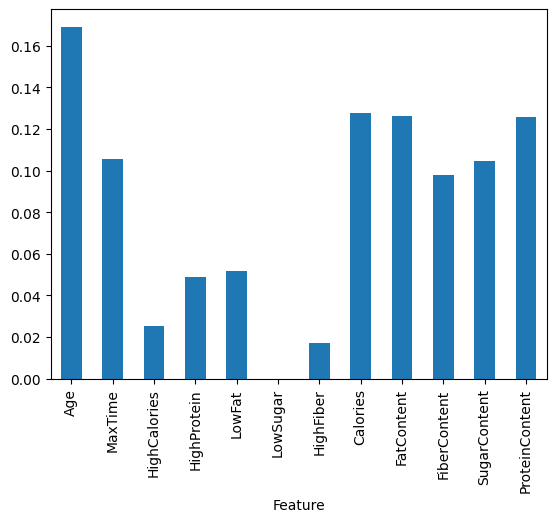

In [53]:
# Plot feature importance 

importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

***Test Model***

In [60]:

#test_df = test_df.drop(columns=["CustomerId", "RecipeId", "Name", "RecipeCategory" , "Diet", "TotalTimeNeeded"])

test_predictions = train_model.predict(test_df.drop(columns=['Like']))
test_probabilities = train_model.predict_proba(test_df.drop(columns=['Like']))

test_predictions_df = pd.DataFrame({'Like': test_df['Like'], 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(test_df['Like'], test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(test_df['Like'], test_predictions))
print("Test-Accuracy:", accuracy_score(test_df['Like'], test_predictions))
print("Test-Recall:", recall_score(test_df['Like'], test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(test_df["Like"], test_predictions))

        Like  Predicted_Like  Probability_Like=0  Probability_Like=1
25014  False             0.0                 0.8                 0.2
39403   True             1.0                 0.4                 0.6
49607  False             0.0                 0.6                 0.4
71706  False             0.0                 1.0                 0.0
641    False             0.0                 1.0                 0.0
...      ...             ...                 ...                 ...
91736  False             0.0                 0.8                 0.2
27086  False             0.0                 1.0                 0.0
51771  False             0.0                 1.0                 0.0
25045  False             0.0                 0.8                 0.2
59991  False             0.0                 1.0                 0.0

[19477 rows x 4 columns]
Confusion Matrix:
[[16044   857]
 [ 1561  1015]]
Test-Precision: 0.5422008547008547
Test-Accuracy: 0.875853570878472
Test-Recall: 0.39402173913043


#### 1. Logistic Regression
#### 2. Decision Trees
#### 3. Random Forest
#### 4. Naive bayes
#### 5. Gradient Boosting

#### 1. Data Cleaning (missing values, merge tables)
#### 2. Set dataset into training & testing sets + download testing set
#### 3. modeling
#### 4. Model training: train model on training dataset
#### 5. Model evaluation (performance)
#### 6. prediction on the unseen data